# Colab Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
"""
Change directory to where this file is located
"""
%cd '/content/drive/Shareddrives/VIPLab/FoDS/HW/FoDS/cnn'

/content/drive/Shareddrives/VIPLab/FoDS/HW/FoDS/cnn


In [3]:
!nvidia-smi

Tue Jul 20 12:20:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Modules

In [4]:
import pathlib
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Data Pipeline

### Prepare Raw Data

In [5]:
(raw_train_ds, raw_val_ds, raw_test_ds), info = tfds.load('tf_flowers',
                                                    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], 
                                                    data_dir = './',
                                                    with_info=True, 
                                                    as_supervised=True)

num_classes = info.features['label'].num_classes
label_names = info.features['label'].names
get_label_name = info.features['label'].int2str

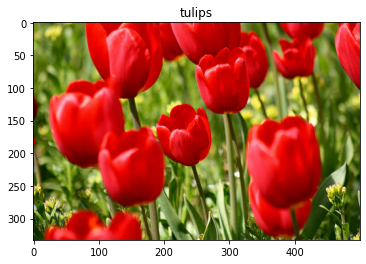

In [6]:
image, label = next(iter(raw_train_ds))
plt.imshow(image)
plt.title(get_label_name(label))
plt.show()

### Preprocess Data

In [7]:
def preprocess(ds, img_shape=(180, 180, 3)):
    resizer = preprocessing.Resizing(height=img_shape[0], width=img_shape[1])
    rescaler = preprocessing.Rescaling(1. / 255)
    def map_func(x):
        x = resizer(x)
        x = rescaler(x)
        return x
    return ds.map(lambda x, y: (map_func(x), y))

In [8]:
print(list(raw_train_ds.as_numpy_iterator())[0][0].shape)
print(list(raw_train_ds.as_numpy_iterator())[0][1])

(333, 500, 3)
2


In [9]:
img_shape = (180, 180, 3)
batch_size = 32

train_ds = preprocess(raw_train_ds, img_shape).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = preprocess(raw_val_ds, img_shape).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = preprocess(raw_test_ds, img_shape).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [10]:
print(list(train_ds.as_numpy_iterator())[0][0].shape)
print(list(train_ds.as_numpy_iterator())[0][1])
print(list(train_ds.as_numpy_iterator())[0][1].shape)

(32, 180, 180, 3)
[3 4 0 2 1 1 0 3 2 0 3 4 3 0 1 3 2 1 2 0 0 1 1 0 2 1 2 4 3 4 2 0]
(32,)


# Model Declaration

In [11]:
model = tf.keras.Sequential([
    layers.Conv2D(input_shape=(180, 180, 3), filters=16, kernel_size=[3, 3], padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(32, [3, 3], padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(100, activation=tf.nn.relu),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics='accuracy')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 45, 45, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 64800)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               6

# Training & Evaluation

In [12]:
epochs = 10
model.fit(train_ds, validation_data=val_ds, epochs=epochs)
# history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)
print("Training DONE")

Epoch 1/10
92/92 [==============================] - 34s 33ms/step - loss: 1.8735 - accuracy: 0.3719 - val_loss: 1.1682 - val_accuracy: 0.5749
Epoch 2/10
92/92 [==============================] - 3s 26ms/step - loss: 1.0787 - accuracy: 0.5739 - val_loss: 1.0850 - val_accuracy: 0.6158
Epoch 3/10
92/92 [==============================] - 3s 25ms/step - loss: 0.8228 - accuracy: 0.6863 - val_loss: 1.1889 - val_accuracy: 0.5341
Epoch 4/10
92/92 [==============================] - 3s 25ms/step - loss: 0.5489 - accuracy: 0.8079 - val_loss: 1.0957 - val_accuracy: 0.5886
Epoch 5/10
92/92 [==============================] - 3s 26ms/step - loss: 0.3094 - accuracy: 0.9074 - val_loss: 1.2789 - val_accuracy: 0.5913
Epoch 6/10
92/92 [==============================] - 3s 26ms/step - loss: 0.1949 - accuracy: 0.9455 - val_loss: 1.3122 - val_accuracy: 0.6022
Epoch 7/10
92/92 [==============================] - 3s 26ms/step - loss: 0.0870 - accuracy: 0.9830 - val_loss: 1.6689 - val_accuracy: 0.5613
Epoch 8/10
9

In [13]:
test_loss, test_acc = model.evaluate(test_ds)
print('Final test accuracy: {}'.format(test_acc))

12/12 [==============================] - 1s 48ms/step - loss: 1.7383 - accuracy: 0.5531
Final test accuracy: 0.553133487701416


In [14]:
def plot_history(history):
    plt.figure(figsize=(12,4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], 'b-', label='train_loss')
    plt.plot(history.history['val_loss'], 'r--', label='val_loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], 'g-', label='train_accuracy')
    plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()

In [15]:
# plot_history(history)

# Model with different depths

In [16]:
model = tf.keras.Sequential([
    layers.Conv2D(input_shape=(180, 180, 3), filters=16, kernel_size=[3, 3], padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(32, [3, 3], padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(64, [3, 3], padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, [3, 3], padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(100, activation=tf.nn.relu),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics='accuracy')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 22, 22, 64)       

In [17]:
epochs = 10
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[callback])
print("Training DONE")
test_loss, test_acc = model.evaluate(test_ds)
print('Final test accuracy: {}'.format(test_acc))

Epoch 1/10
92/92 [==============================] - 4s 30ms/step - loss: 1.3316 - accuracy: 0.3982 - val_loss: 1.1254 - val_accuracy: 0.5477
Epoch 2/10
92/92 [==============================] - 3s 28ms/step - loss: 1.0598 - accuracy: 0.5668 - val_loss: 0.9906 - val_accuracy: 0.6076
Epoch 3/10
92/92 [==============================] - 3s 28ms/step - loss: 0.9627 - accuracy: 0.6216 - val_loss: 0.9627 - val_accuracy: 0.6076
Epoch 4/10
92/92 [==============================] - 3s 27ms/step - loss: 0.8542 - accuracy: 0.6621 - val_loss: 0.8960 - val_accuracy: 0.6458
Epoch 5/10
92/92 [==============================] - 3s 26ms/step - loss: 0.7681 - accuracy: 0.7088 - val_loss: 0.8601 - val_accuracy: 0.6403
Epoch 6/10
92/92 [==============================] - 3s 28ms/step - loss: 0.6855 - accuracy: 0.7323 - val_loss: 0.8296 - val_accuracy: 0.6757
Epoch 7/10
92/92 [==============================] - 3s 27ms/step - loss: 0.5788 - accuracy: 0.7851 - val_loss: 0.8555 - val_accuracy: 0.6812
Epoch 8/10
92

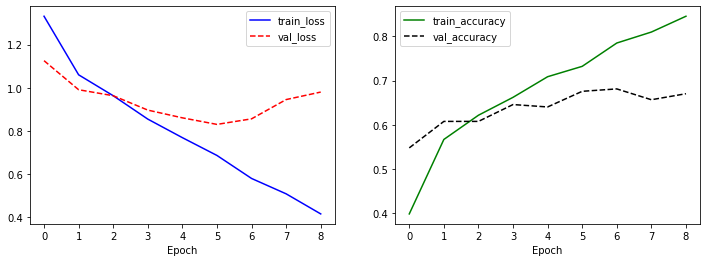

In [18]:
plot_history(history)

# Model Class Declaration

In [19]:
class CNN(tf.keras.Model):
    def __init__(self, input_dim, channel1, channel2, channel3, fc_size, num_classes):
        super(CNN, self).__init__(name="CNN")

        # Data augmentation layers
        self.aug_rotate = preprocessing.RandomRotation(0.1)
        self.aug_flip = preprocessing.RandomFlip("horizontal", input_shape=(input_dim[0], input_dim[1], 3))
        self.aug_zoom = preprocessing.RandomZoom(0.1)
        self.aug_brightness = self.random_adjust_brightness()

        # Main layers
        self.conv1 = layers.Conv2D(channel1, [3, 3], padding='same', activation=tf.nn.relu)
        self.pool1 = layers.MaxPooling2D(pool_size=(2, 2))
        self.conv2 = layers.Conv2D(channel2, [3, 3], padding='same', activation=tf.nn.relu)
        self.pool2 = layers.MaxPooling2D(pool_size=(2, 2))
        self.conv3 = layers.Conv2D(channel3, [3, 3], padding='same', activation=tf.nn.relu)
        self.pool3 = layers.MaxPooling2D(pool_size=(2, 2))
        self.dropout = layers.Dropout(0.2)
        self.flat = layers.Flatten()
        self.fc1 = layers.Dense(fc_size, activation=tf.nn.relu)
        self.fc2 = layers.Dense(num_classes)

    def random_adjust_brightness(self):
        def random_adjust_brightness_aux(x):
            brightness = np.random.random_sample()
            return tf.image.adjust_brightness(x, brightness)
        return layers.Lambda(lambda x: random_adjust_brightness_aux(x))

    def call(self, x, training=False):
        # Data augmentation layers
        x = self.aug_rotate(x)
        x = self.aug_flip(x)
        x = self.aug_zoom(x)
        x = self.aug_brightness(x)

        # Main layers
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.dropout(x)
        x = self.flat(x)
        x = self.fc1(x)
        x = self.fc2(x)

        return x

In [20]:
class CNN(tf.keras.Model):
    def __init__(self, input_dim, channel1, channel2, channel3, fc_size, num_classes):
        super(CNN, self).__init__(name="CNN")

        # Data augmentation layers
        self.augment = tf.keras.Sequential([
            preprocessing.RandomRotation(0.1),
            preprocessing.RandomFlip("horizontal", input_shape=(input_dim[0], input_dim[1], 3)),
            preprocessing.RandomZoom(0.1),
            self.random_adjust_brightness(),
        ])

        # Main layers
        self.main = tf.keras.Sequential([
            layers.Conv2D(channel1, [3, 3], padding='same', activation=tf.nn.relu),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(channel2, [3, 3], padding='same', activation=tf.nn.relu),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(channel3, [3, 3], padding='same', activation=tf.nn.relu),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Dropout(0.2),
            layers.Flatten(),
            layers.Dense(fc_size, activation=tf.nn.relu),
            layers.Dense(num_classes)
        ])

    def random_adjust_brightness(self):
        def random_adjust_brightness_aux(x):
            brightness = np.random.random_sample()
            return tf.image.adjust_brightness(x, brightness)
        return layers.Lambda(lambda x: random_adjust_brightness_aux(x))

    def call(self, x, training=False):
        # Data augmentation layers
        x = self.augment(x)
        # Main layers
        x = self.main(x)
        return x

In [21]:
model = CNN(input_dim=img_shape, channel1=16, channel2=32, channel3=64, fc_size=128, num_classes=num_classes)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics='accuracy')

In [22]:
epochs = 20
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[callback])
print("Training DONE")

Epoch 1/20
92/92 [==============================] - 4s 29ms/step - loss: 1.4370 - accuracy: 0.3842 - val_loss: 1.2046 - val_accuracy: 0.5286
Epoch 2/20
92/92 [==============================] - 3s 28ms/step - loss: 1.1468 - accuracy: 0.5276 - val_loss: 1.2630 - val_accuracy: 0.5014
Epoch 3/20
92/92 [==============================] - 3s 27ms/step - loss: 1.0948 - accuracy: 0.5743 - val_loss: 1.1897 - val_accuracy: 0.5041
Epoch 4/20
92/92 [==============================] - 3s 27ms/step - loss: 1.0183 - accuracy: 0.6063 - val_loss: 1.1104 - val_accuracy: 0.5913
Epoch 5/20
92/92 [==============================] - 3s 27ms/step - loss: 0.9591 - accuracy: 0.6250 - val_loss: 1.0081 - val_accuracy: 0.6213
Epoch 6/20
92/92 [==============================] - 3s 28ms/step - loss: 0.9334 - accuracy: 0.6335 - val_loss: 1.1315 - val_accuracy: 0.5395
Epoch 7/20
92/92 [==============================] - 3s 29ms/step - loss: 0.8889 - accuracy: 0.6533 - val_loss: 0.9342 - val_accuracy: 0.6294
Epoch 8/20
92

In [23]:
model.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 5)                 3989285   
Total params: 3,989,285
Trainable params: 3,989,285
Non-trainable params: 0
_________________________________________________________________


In [24]:
test_loss, test_acc = model.evaluate(test_ds)
print('Final test accuracy: {}'.format(test_acc))

12/12 [==============================] - 0s 15ms/step - loss: 0.9086 - accuracy: 0.6621
Final test accuracy: 0.6621253490447998


In [25]:
predictions = model.predict(test_ds)
tf.math.argmax(predictions, 1)

<tf.Tensor: shape=(367,), dtype=int64, numpy=
array([2, 0, 0, 1, 0, 2, 2, 3, 3, 0, 1, 4, 3, 4, 0, 3, 2, 0, 4, 4, 2, 0,
       1, 0, 1, 3, 4, 2, 4, 3, 0, 4, 2, 1, 2, 1, 2, 0, 1, 3, 0, 3, 3, 0,
       1, 1, 0, 0, 4, 2, 0, 4, 4, 1, 1, 4, 0, 1, 1, 4, 4, 3, 3, 3, 1, 1,
       3, 3, 3, 3, 2, 4, 4, 1, 0, 3, 1, 2, 2, 3, 4, 4, 1, 4, 1, 3, 2, 2,
       1, 1, 1, 0, 3, 1, 3, 3, 3, 3, 2, 4, 3, 4, 4, 4, 2, 1, 3, 4, 4, 1,
       2, 2, 2, 1, 4, 0, 4, 0, 1, 1, 2, 1, 4, 4, 2, 4, 3, 0, 3, 3, 0, 4,
       2, 1, 3, 3, 2, 2, 2, 2, 3, 1, 3, 2, 1, 4, 1, 1, 3, 4, 3, 1, 4, 3,
       0, 3, 2, 3, 2, 1, 4, 4, 1, 1, 1, 1, 4, 2, 3, 1, 1, 2, 4, 4, 2, 4,
       1, 1, 0, 3, 1, 2, 3, 2, 4, 4, 1, 3, 3, 2, 1, 0, 1, 2, 2, 2, 4, 1,
       3, 4, 0, 4, 2, 2, 1, 3, 3, 1, 0, 2, 4, 1, 3, 3, 4, 2, 3, 1, 2, 3,
       2, 3, 3, 4, 2, 2, 0, 0, 1, 3, 1, 1, 4, 3, 1, 3, 1, 3, 1, 3, 3, 3,
       3, 1, 3, 1, 4, 4, 3, 1, 2, 0, 4, 0, 3, 3, 0, 0, 3, 1, 1, 4, 0, 4,
       3, 2, 1, 1, 0, 1, 1, 3, 0, 3, 1, 4, 1, 3, 0, 2, 2, 2, 2, 3, 0, 3,
     

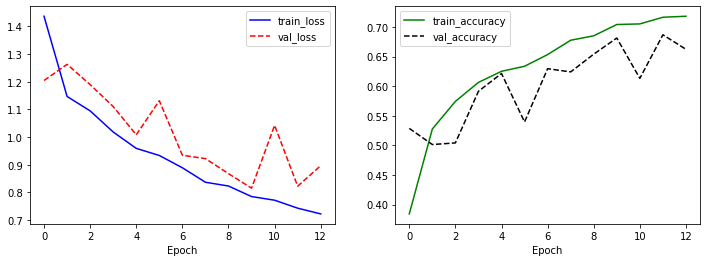

In [26]:
plot_history(history)

# Try more options to fully optimize the model!

For more details, please refer to https://www.tensorflow.org/api_docs/python/tf.


In [ ]:
# activations
tf.nn.relu
tf.nn.sigmoid
tf.nn.tanh

# optimizers
tf.keras.optimizers.Adam() # 'adam'
tf.keras.optimizers.RMSprop() # 'rmsprop'
tf.keras.optimizers.SGD() # 'sgd'

# loss
tf.keras.losses.BinaryCrossentropy()
tf.keras.losses.CategoricalCrossentropy() # one-hot representation ex) [1,0,0,0]
tf.keras.losses.MeanAbsoluteError()
tf.keras.losses.MeanSquaredError()
tf.keras.losses.SparseCategoricalCrossentropy() # integer representation ex) 0, 1, 2, ...

# metrics
['accuracy'] # classification problems
['mse'] # regression problems

In [ ]:
class CustomCNN(tf.keras.Model):
    def __init__(self, input_dim, num_classes):
        super(CustomCNN, self).__init__(name="CustomCNN")

        self.augment = tf.keras.Sequential([
            preprocessing.RandomRotation(0.1),
            preprocessing.RandomFlip("horizontal", input_shape=(input_dim[0], input_dim[1], 3)),
            preprocessing.RandomZoom(0.1),
            self.random_adjust_brightness(),
        ])

        self.main = tf.keras.Sequential([
            ## add your own layers!
            


            layers.Dense(num_classes),
        ])

    def random_adjust_brightness(self):
        def random_adjust_brightness_aux(x):
            brightness = np.random.random_sample()
            return tf.image.adjust_brightness(x, brightness)
        return layers.Lambda(lambda x: random_adjust_brightness_aux(x))

    def call(self, x, training=False):
        x = self.augment(x)
        x = self.main(x)
        return x

In [ ]:
my_model = CustomCNN(input_dim=img_shape, num_classes=num_classes)
my_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics='accuracy')

In [ ]:
epochs = 20
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
my_history = my_model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[callback])
print("Training DONE")

test_loss, test_acc = my_model.evaluate(test_ds)
print('Final test accuracy: {}'.format(test_acc))

In [ ]:
plot_history(my_history)